In [1]:
rm(list=ls())
library(car)
setwd("D:/2019 Fall/STAT 628/module 2/data")
data = read.csv("data_cleaned.csv")[,-c(1,3)]

Loading required package: carData


### Review of original linear regression model

In [2]:
m = lm(BODYFAT~.,data)
coefficients(summary(m))
cat("Adjusted R-squared:",summary(m)$adj.r.squared,"  R-squared:",summary(m)$r.squared,
    "  MSE:",sum(summary(m)$residuals^2)/(nrow(data)-ncol(data)))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-12.10145782,38.14717994,-0.3172307,7.513551e-01
AGE,0.05478405,0.03034241,1.8055274,7.229408e-02
WEIGHT,-0.05540905,0.10668445,-0.5193732,6.039978e-01
HEIGHT,0.06171519,0.52951955,0.1165494,9.073184e-01
ADIPOSITY,0.39174132,0.76935979,0.5091783,6.111133e-01
NECK,-0.38398818,0.21677764,-1.7713459,7.782170e-02
CHEST,-0.12634161,0.10438661,-1.2103239,2.273916e-01
ABDOMEN,0.82871447,0.08613884,9.6206829,1.215296e-18
HIP,-0.20688061,0.13776328,-1.5017108,1.345375e-01
THIGH,0.16861269,0.13829847,1.2191942,2.240140e-01


Adjusted R-squared: 0.7188665   R-squared: 0.7349313   MSE: 15.40371

From the summary of the model, it can be seen that there exists some insignificant predictors;

Besides, we will show there is multi-colinearity relationship between design matrix.

#### Colinearity in design matrix

In [3]:
cat("The maximum vif value of design matrix X is: ",max(vif(m)),sep="")
mat = as.matrix(data[-1])
cat("\n The k condition number of design matrix X is: ",max(eigen(t(mat)%*%mat)$values)/min(eigen(t(mat)%*%mat)$values),sep="")

The maximum vif value of design matrix X is: 128.532
 The k condition number of design matrix X is: 357615.1

Thus, for computational efficiency and multi-colinearity solution, apply step-wise regression with different directions and criteria ti do variables selection.

### Variables selection

#### Split data

Here we set seed to 628 and split data into training set: validation set = 3:4.

In [4]:
n = nrow(data)
set.seed(628)
index = sample(1:n,floor(3*n/4))
train = data[index,]
test = data[-index,]
m = lm(train$BODYFAT~.,train)

#### Variables selection

Here, we use AIC and BIC criteria with 3 directions to select variables. For a linear regression model with design matrix $X_{n\times k}$, 
$$AIC = 2k-2\ln{L}$$
$$BIC = k\ln{n}-2\ln{L}$$
where $L = (2\pi)^{-\frac{kn}{2}}|{\Sigma}|^{-\frac{n}{2}} e^{\frac{1}{2}\Sigma_{i=1}^n(x_i-\mu)^T\Sigma^{-1}(x_i-\mu)}$ is the likelihood function under normality assumption.
The different directions represent methods of adding or deleting predictors to select the model with lowest AIC/BIC.

In [5]:
index = function(m,show=F){
  if(show==T){
    print(m)
  }
  return(names(coefficients(m)[-1]))
}

#### AIC criterion

In [6]:
aic.both = index(step(m,direction="both",k=2,trace=0))
aic.back = index(step(m,direction="backward",k=2,trace=0))
aic.for = index(step(m,direction="forward",k=2,trace=0))

#### BIC criterion

In [7]:
n=nrow(train);p=ncol(train[,-1])
bic.both = index(step(m,direction="both",k=log(n),trace=0))
bic.back = index(step(m,direction="backward",k=log(n),trace=0))
bic.for = index(step(m,direction="forward",k=log(n),trace=0))

#### Summary

In [8]:
df = data.frame("model"=paste("model",1:3),
               "variables"=rbind(paste(aic.both,collapse=","),
                                paste(bic.both,collapse=","),
                                "full model"),
               "info"=rbind("best AIC model with direction 'both' and 'backward'",
                           "best BIC model with direction 'both' and 'backward'",
                           "best model with AIC, BIC forward direction."))
df

model,variables,info
<fct>,<fct>,<fct>
model 1,"AGE,WEIGHT,ABDOMEN,THIGH,FOREARM,WRIST",best AIC model with direction 'both' and 'backward'
model 2,"WEIGHT,ABDOMEN,WRIST",best BIC model with direction 'both' and 'backward'
model 3,full model,"best model with AIC, BIC forward direction."


As our goal is selecting variables, we just compare model 1 and model 2 in the following analysis.

### Models selection

#### Comparison on the training set

In [9]:
candidate = unique(list(aic.both,aic.back,bic.both,bic.back))
model.num = length(candidate)
for(i in 1:model.num){
  assign(paste("m",i,sep=""), lm(train$BODYFAT~.,train[,candidate[[i]]]))
}

In [10]:
model.extract=function(model){
  r = model$residuals
  s = summary(model)
  adjr2 = s$adj.r.squared
  r2 = s$r.squared
  rss = sum(r^2)
  p.value = shapiro.test(r)$p.value
  vif = max(vif(model))
  out = c(r2,adjr2,rss/(length(r)-1),p.value,vif)
  names(out) = c("R-squared","Adjusted R-squared","MSE","p.value","vif.max")
  return(out)
}

In [11]:
comp = rbind(model.extract(m1),model.extract(m2))
rownames(comp) = paste("m",1:2,sep="")
cat("2 models comparison:\n")
print(comp)

2 models comparison:
   R-squared Adjusted R-squared      MSE   p.value   vif.max
m1 0.7400173          0.7312043 13.88465 0.2392605 11.523178
m2 0.7272641          0.7227185 14.56575 0.2177470  5.199095


model 1 diagnostic graphics:


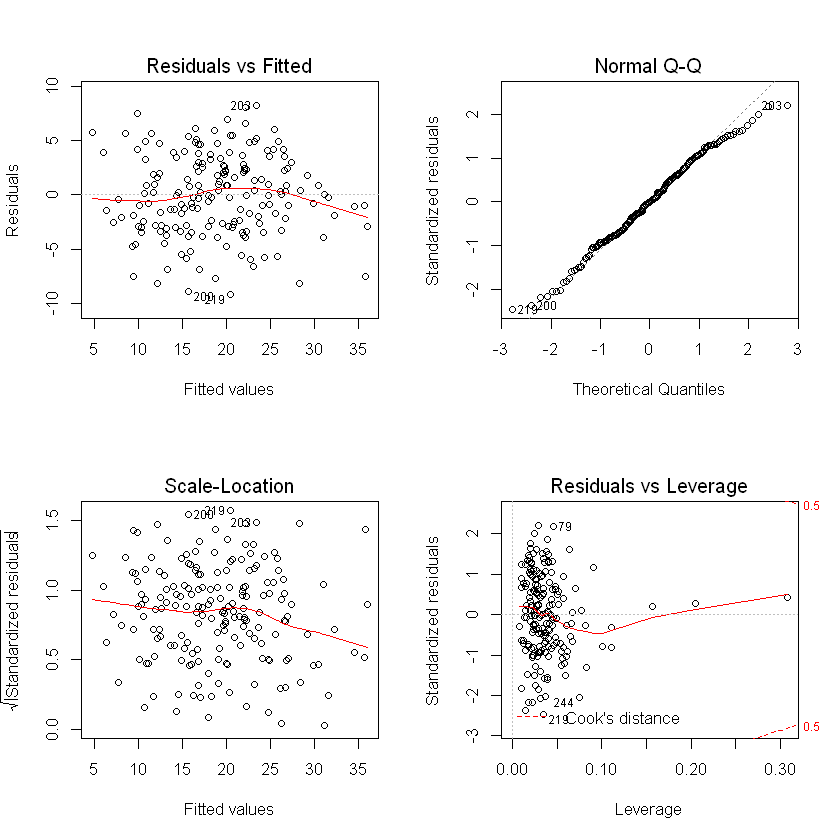

In [12]:
par(mfrow=c(2,2))
cat("model 1 diagnostic graphics:\n")
plot(m1)

model 2 diagnostic graphics:


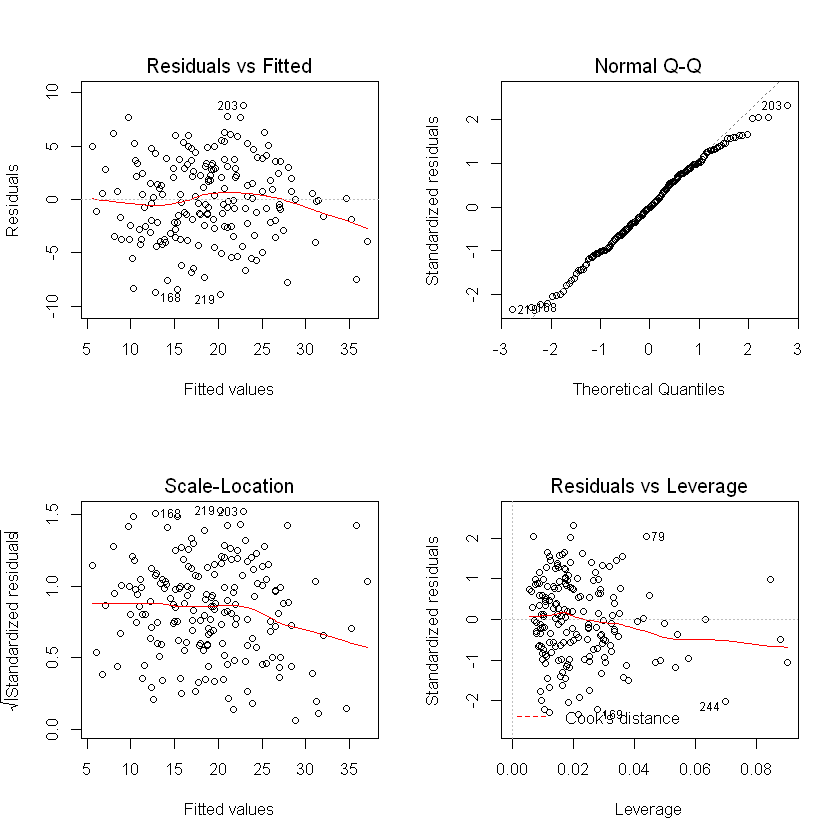

In [13]:
par(mfrow=c(2,2))
cat("model 2 diagnostic graphics:\n")
plot(m2)
par(mfrow=c(1,1))

#### Performances on the validation set

In [14]:
calculate = function(model,ind){
  test.X = test[,ind]
  y = test$BODYFAT
  y.hat = predict.lm(model,test.X)
  r = y-y.hat
  rss = sum(r^2)
  sst = sum((y-mean(y))^2)
  r2 = 1-rss/sst
  adjr2 = 1-(rss/(nrow(test.X)-1))/(sst/(nrow(test.X)-ncol(test.X)-1))
  p.value = shapiro.test(r)$p.value
  outcome = list("R-squared"=r2,
                 "Adjusted R-squared"=adjr2,
                 "p.value"=p.value,
                 "residuals"=r)
  return(outcome)
}

o1 = calculate(m1,candidate[[1]])
o2 = calculate(m2,candidate[[2]])
comp.test = rbind(c(o1$`R-squared`,o1$`Adjusted R-squared`,sum(o1$residuals^2)/(nrow(test)-ncol(test)),o1$p.value),
                  c(o2$`R-squared`,o2$`Adjusted R-squared`,sum(o2$residuals^2)/(nrow(test)-ncol(test)),o2$p.value))
colnames(comp.test) = c("R-squared","Adjusted R-squared","MSE","p.value")
rownames(comp.test) = paste("m",1:2,sep="")

In [15]:
cat("models' performances on the training set:\n")
print(comp)
cat("\nmodels' performances on the test set:\n")
print(comp.test)

models' performances on the training set:
   R-squared Adjusted R-squared      MSE   p.value   vif.max
m1 0.7400173          0.7312043 13.88465 0.2392605 11.523178
m2 0.7272641          0.7227185 14.56575 0.2177470  5.199095

models' performances on the test set:
   R-squared Adjusted R-squared      MSE    p.value
m1 0.6820784          0.7133493 24.49591 0.35590722
m2 0.6854863          0.7009542 24.23332 0.07466635


From tables above, it can be concluded that model 1 still has multicolinearity between design matrix. Model 2' $R^2_{adj}$ decreases not serious and has lower MSE compared with model 1, althouhg its risiduals are less likely normally distributed , but it's still good enough to be the final model.

Then we refit the model 2 on the whole dateset.

### Refit model

In [16]:
ind = candidate[[2]]
data.select = data[,c("BODYFAT",candidate[[2]])]
m = lm(BODYFAT~.,data.select)
cbind(coefficients(summary(m))[,-3],confint(m))
cat("Adjusted R-squared:",summary(m)$adj.r.squared,"  R-squared:",summary(m)$r.squared,
    "  MSE:",sum(summary(m)$residuals^2)/(nrow(data)-ncol(data)))

,Estimate,Std. Error,Pr(>|t|),2.5 %,97.5 %
(Intercept),-23.86796500,6.20448216,1.530561e-04,-36.0896479,-11.64628215
WEIGHT,-0.08350773,0.02229762,2.253849e-04,-0.1274299,-0.03958554
ABDOMEN,0.86989031,0.05185147,1.996194e-42,0.7677525,0.97202812
WRIST,-1.24546008,0.40111071,2.129234e-03,-2.0355740,-0.45534613


Adjusted R-squared: 0.7145848   R-squared: 0.7180797   MSE: 16.38299

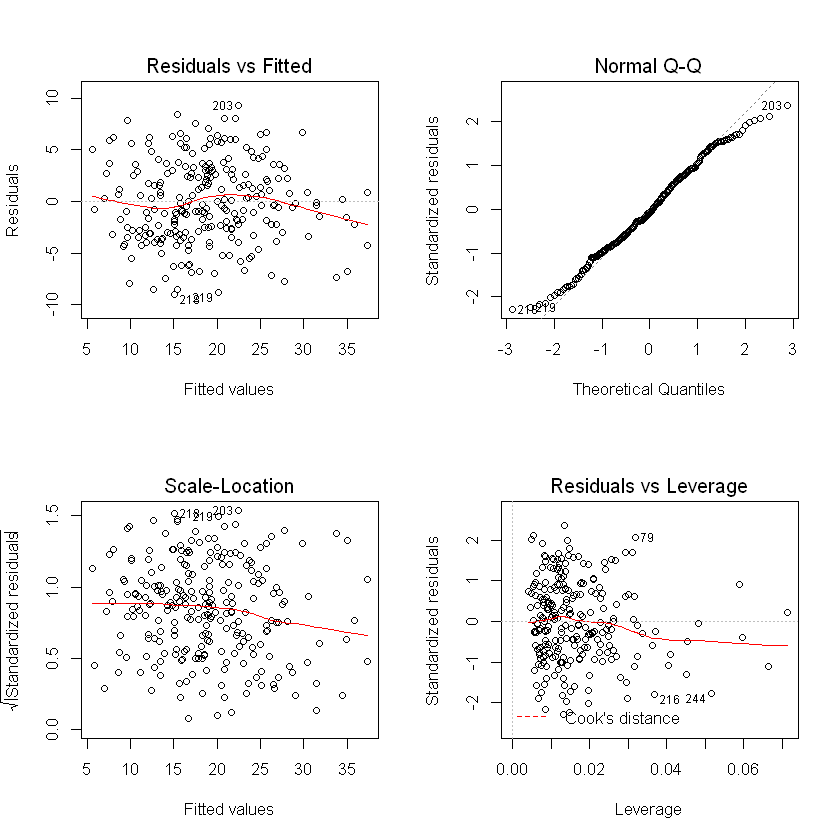

In [17]:
par(mfrow=c(2,2))
plot(m)